In [336]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Data Prep and Daily Returns and Interest Rate Differentials Calculations**


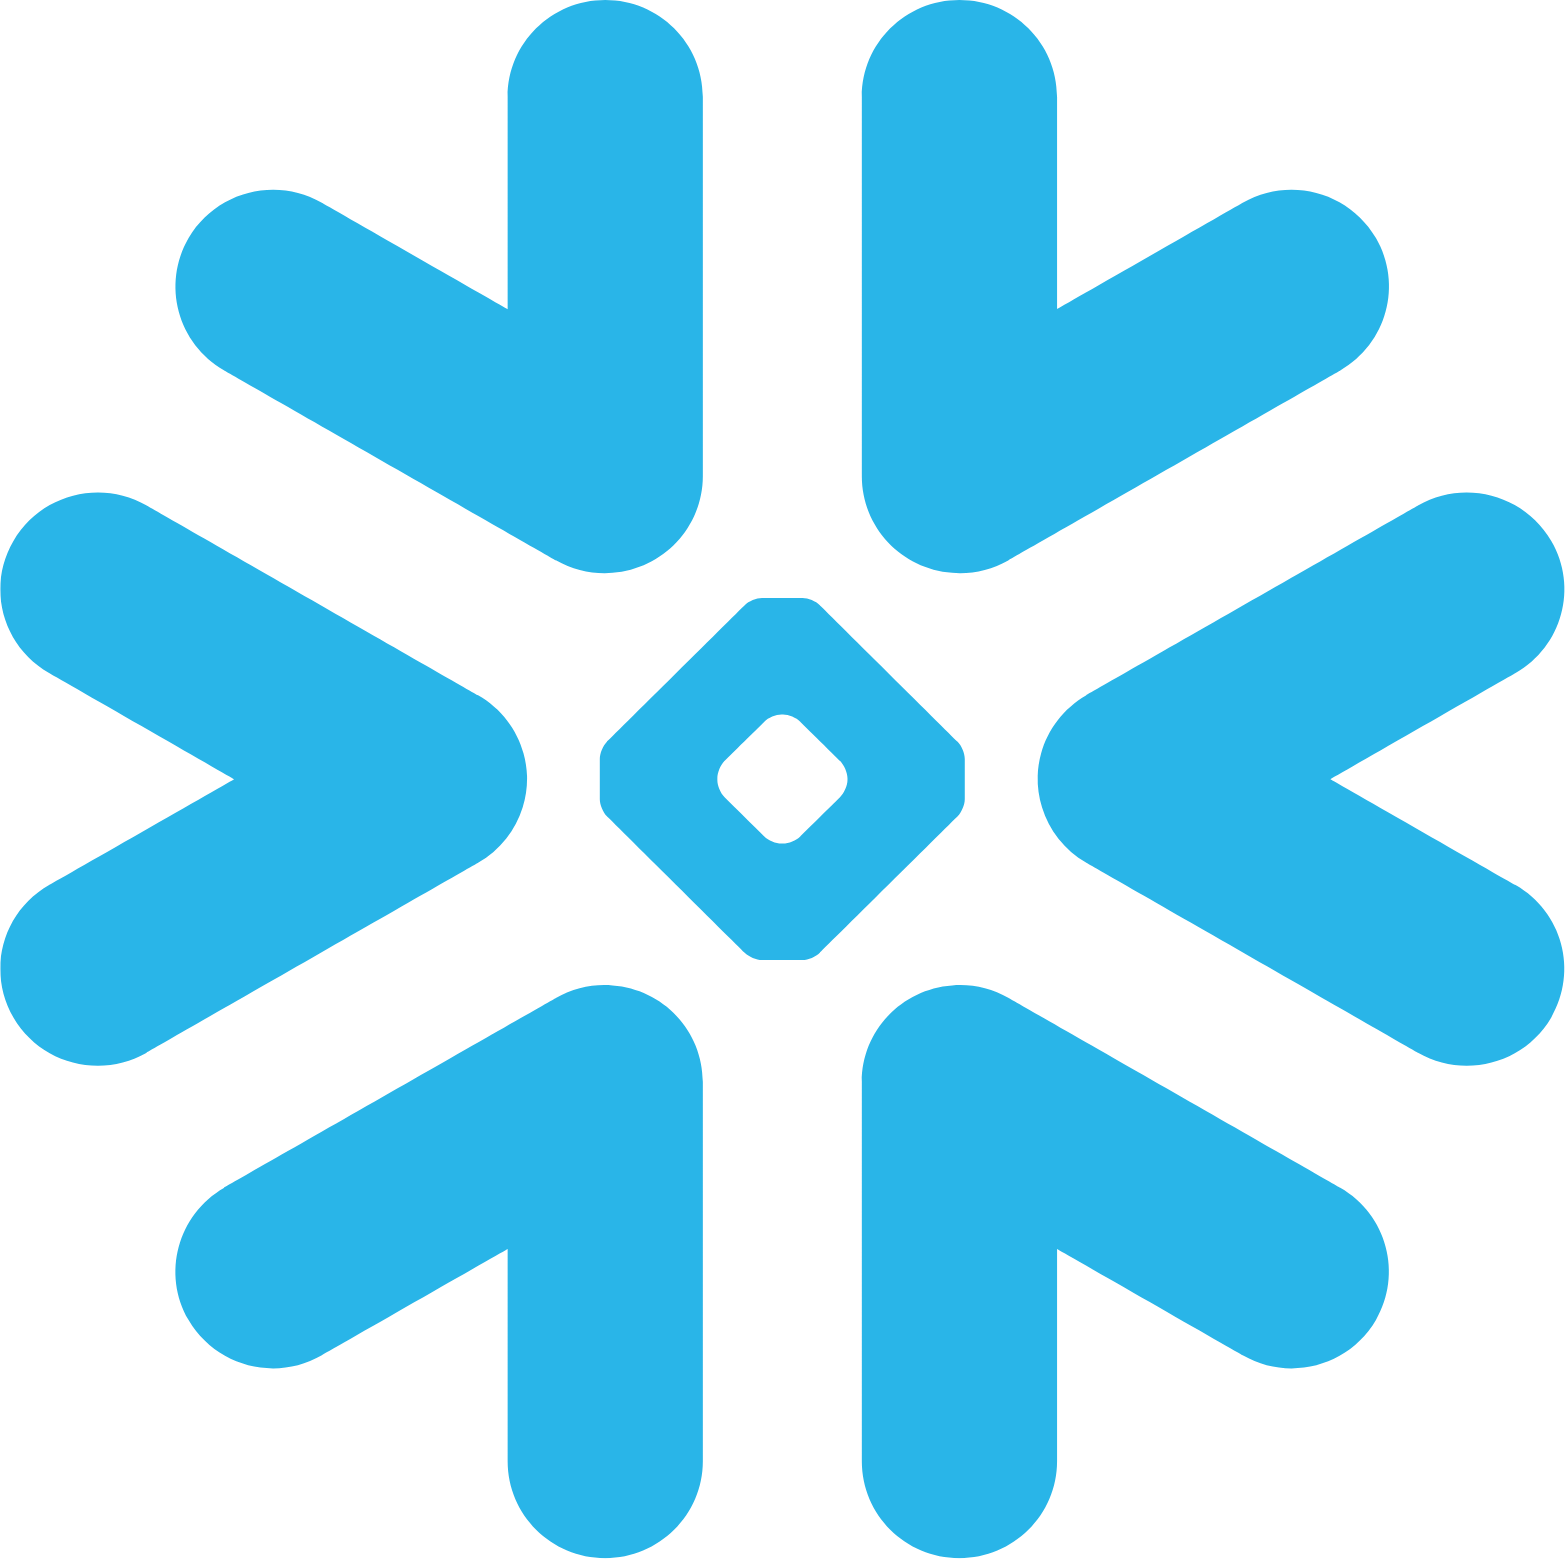

In [465]:
#Load FX Rates
fx_rates = {}
fx_pairs = ['EURUSD','EURGBP', 'EURCAD', 'EURCHF', 'EURNOK', 'EURJPY']

for pair in fx_pairs:
    file_name = f"ECB Data Portal_{pair}.csv"
    df = pd.read_csv(file_name)
    old_col_name = df.columns[2]
    new_col_name = old_col_name.split(' (')[0]
    df = df.rename(columns = {old_col_name : new_col_name})
    df = df.drop('TIME PERIOD', axis = 1)
    fx_rates[pair] = df.set_index('DATE')
#Load Risk-Free Rates
rf_rates_3m = {}
rf_rates_6m = {}
countries = {'EU', 'NO', 'US', 'CH', 'JP', 'CA', 'UK'}

for country in countries:
    file_name_3m = f"{country}RFR3Mo.csv"
    file_name_6m = f"{country}RFR6Mo.csv"
    df_3m = pd.read_csv(file_name_3m)
    df_6m = pd.read_csv(file_name_6m)
    df_3m = df_3m.rename(columns={'Rate': f'{country} Rate_3mo'})
    df_6m = df_6m.rename(columns={'Rate': f'{country} Rate_6Mo'})
    rf_rates_3m[country] = df_3m.set_index('Date')
    rf_rates_6m[country] = df_6m.set_index('Date')

fx_rates_df = pd.concat(fx_rates.values(), axis = 1)
fx_rates_df.index = pd.to_datetime(fx_rates_df.index)


rf_rates_3m = pd.concat(rf_rates_3m.values(), axis = 1)
rf_rates_3m.index = pd.to_datetime(rf_rates_3m.index)
rf_rates_6m = pd.concat(rf_rates_6m.values(), axis = 1)
rf_rates_6m.index = pd.to_datetime(rf_rates_6m.index)
 

# Merge the dataframes on the index (Date)
merged_df = fx_rates_df.merge(rf_rates_3m, left_index=True, right_index=True, how='outer')
merged_df = merged_df.merge(rf_rates_6m, left_index=True, right_index=True, how='outer')
merged_df = merged_df.ffill()
merged_df['JP Rate_3mo'] = merged_df['JP Rate_3mo'].fillna(merged_df['JP Rate_6Mo'])
merged_df.index_name = 'Date'
merged_df = merged_df.dropna()

#Converting base/quote currencies by interest rate differentials (EUR Higher, then the other currency is the base currency)
reciprocal_columns = {
    #'Euro/US dollar': 'US dollar/Euro',
    'Euro/Swiss franc': 'Swiss franc/Euro',
    #'Euro/Norwegian krone': 'Norwegian krone/Euro',
    'Euro/Japanese yen': 'Japanese yen/Euro'
}

for original, reciprocal in reciprocal_columns.items():
    merged_df[reciprocal] = 1 / merged_df[original]



fx_pairs = {'Euro/UK pound sterling', 'Euro/Canadian dollar', 'Euro/US dollar', 'Swiss franc/Euro', 'Euro/Norwegian krone', 'Japanese yen/Euro'}

for pair in fx_pairs:
    merged_df[f'{pair}_return'] = (merged_df[pair].pct_change())*100



currency_country = {'Euro' : 'EU',
                    'Canadian dollar' : 'CA',
                    'Swiss franc' : 'CH',
                    'Norwegian krone' : 'NO',
                    'US dollar' : 'US',
                    'Japanese yen' : 'JP',
                    'UK pound sterling' : 'UK'}

 # Calculate Interest Rate differentials    
for pair in fx_pairs:
    base_currency = pair.split('/')[0]  # Get the base currency
    quote_currency = pair.split('/')[1]  # Get the quote currency
    base_rate_col = f'{currency_country[base_currency]} Rate_3mo'  # Base currency rate column
    quote_rate_col = f'{currency_country[quote_currency]} Rate_3mo'  # Quote currency rate column

    if base_rate_col in merged_df.columns and quote_rate_col in merged_df.columns:
        merged_df[f'{pair}_diff_3m'] = merged_df[quote_rate_col] - merged_df[base_rate_col] 

for pair in fx_pairs:
    base_currency = pair.split('/')[0]  # Get the base currency
    quote_currency = pair.split('/')[1]  # Get the quote currency
    base_rate_col = f'{currency_country[base_currency]} Rate_3mo'  # Base currency rate column
    quote_rate_col = f'{currency_country[quote_currency]} Rate_3mo'  # Quote currency rate column

    if base_rate_col in merged_df.columns and quote_rate_col in merged_df.columns:
        merged_df[f'{pair}_diff_3m'] = merged_df[quote_rate_col] - merged_df[base_rate_col]
       
for pair in fx_pairs:
    base_currency = pair.split('/')[0]  # Get the base currency
    quote_currency = pair.split('/')[1]  # Get the quote currency
    base_rate_col = f'{currency_country[base_currency]} Rate_6Mo'  # Base currency rate column
    quote_rate_col = f'{currency_country[quote_currency]} Rate_6Mo'  # Quote currency rate column

    if base_rate_col in merged_df.columns and quote_rate_col in merged_df.columns:
        merged_df[f'{pair}_diff_6m'] = merged_df[quote_rate_col] - merged_df[base_rate_col]   
display(merged_df.tail())

**Uncovered Currency Carry Trade Strategy 20 Year Historical Performance**

In [467]:
#Calculate Total Daily Returns from the Carry Trades: Interest Rate Differential + FX Rate change
# Calculate Total Daily Returns from the Carry Trades: Interest Rate Differential + FX Rate change
cumulative_returns_3m = {}
cumulative_returns_6m = {}
annualized_returns_3m = {}
annualized_returns_6m = {}
annualized_volatilities_3m = {}
annualized_volatilities_6m = {}
annualized_sharpe_ratios_3m = {}
annualized_sharpe_ratios_6m = {}
max_drawdowns_3m = {}
max_drawdowns_6m = {}
for pair in fx_pairs:
    merged_df[f'{pair} Carry_Returns_3m'] = merged_df[f'{pair}_return'] + (merged_df[f'{pair}_diff_3m']/365)
    merged_df[f'{pair} Carry_Returns_6m'] = merged_df[f'{pair}_return'] + (merged_df[f'{pair}_diff_6m']/365)
    cumulative_returns_3m[pair] = ((1 + (merged_df[f'{pair} Carry_Returns_3m']/100)).cumprod() - 1)*100
    cumulative_returns_3m[pair] = ((1 + (merged_df[f'{pair} Carry_Returns_3m']/100)).cumprod() - 1) * 100
    cumulative_returns_6m[pair] = (1 + merged_df[f'{pair} Carry_Returns_6m']).cumprod() - 1
    annualized_returns_3m[pair] = merged_df[f'{pair} Carry_Returns_3m'].mean() * 252 #Assuming 252 trading days
    annualized_returns_3m[pair] = merged_df[f'{pair} Carry_Returns_3m'].mean() * 252  # Assuming 252 trading days
    annualized_returns_6m[pair] = merged_df[f'{pair} Carry_Returns_6m'].mean() * 252
    annualized_volatilities_3m[pair] = merged_df[f'{pair} Carry_Returns_3m'].std() * np.sqrt(252)
    annualized_volatilities_6m[pair] = merged_df[f'{pair} Carry_Returns_6m'].std() * np.sqrt(252)
    annualized_sharpe_ratios_3m[pair] = (annualized_returns_3m[pair] / annualized_volatilities_3m[pair])
    annualized_sharpe_ratios_6m[pair] = (annualized_returns_6m[pair] / annualized_volatilities_6m[pair])
    merged_df[f'{pair} Cum_Returns_3m'] = ((1 + (merged_df[f'{pair} Carry_Returns_3m']/100)).cumprod() - 1)*100
    merged_df[f'{pair} Cum_Returns_6m'] = ((1 + (merged_df[f'{pair} Carry_Returns_6m']/100)).cumprod() - 1)*100
    def max_drawdown(returns):
        peak = returns.cummax()
        drawdown = (returns - peak) / peak
        return drawdown.min()
        
    max_drawdowns_3m[pair] = max_drawdown(merged_df[f'{pair} Carry_Returns_3m'])
    max_drawdowns_6m[pair] = max_drawdown(merged_df[f'{pair} Carry_Returns_6m'])

for pair in fx_pairs:
    print(f"--- {pair} & 3 Month Yield Rates---")

    print("\nAnnualized Return:")
    print(f"{annualized_returns_3m[pair]:.3f}%")

    print("\nAnnualized Volatility:")
    print(f"{annualized_volatilities_3m[pair]:.3f}%")

    print("\nAnnualized Sharpe Ratio:")
    print(f"{annualized_sharpe_ratios_3m[pair]:.3f}")

    print("\nMaximum Drawdown:")
    print(f"{max_drawdowns_3m[pair]:.3f}%")

for pair in fx_pairs:
    print(f"--- {pair} & 6 Month Yield Rates ---")
    

    print("\nAnnualized Return:")
    print(f"{annualized_returns_6m[pair]:.3f}%")

    print("\nAnnualized Volatility:")
    print(f"{annualized_volatilities_6m[pair]:.3f}%")

    print("\nAnnualized Sharpe Ratio:")
    print(f"{annualized_sharpe_ratios_6m[pair]:.3f}")

    print("\nMaximum Drawdown:")
    print(f"{max_drawdowns_6m[pair]:.3f}%")

--- Euro/Canadian dollar & 3 Month Yield Rates---

Annualized Return:
0.717%

Annualized Volatility:
7.955%

Annualized Sharpe Ratio:
0.090

Maximum Drawdown:
-2.327%
--- Swiss franc/Euro & 3 Month Yield Rates---

Annualized Return:
2.719%

Annualized Volatility:
6.381%

Annualized Sharpe Ratio:
0.426

Maximum Drawdown:
-3.324%
--- Japanese yen/Euro & 3 Month Yield Rates---

Annualized Return:
0.260%

Annualized Volatility:
9.882%

Annualized Sharpe Ratio:
0.026

Maximum Drawdown:
-2.167%
--- Euro/Norwegian krone & 3 Month Yield Rates---

Annualized Return:
2.422%

Annualized Volatility:
7.524%

Annualized Sharpe Ratio:
0.322

Maximum Drawdown:
-5.775%
--- Euro/UK pound sterling & 3 Month Yield Rates---

Annualized Return:
1.719%

Annualized Volatility:
6.968%

Annualized Sharpe Ratio:
0.247

Maximum Drawdown:
-2.200%
--- Euro/US dollar & 3 Month Yield Rates---

Annualized Return:
0.158%

Annualized Volatility:
7.969%

Annualized Sharpe Ratio:
0.020

Maximum Drawdown:
-2.465%
--- Euro/

**Cumulative Returns over time for Currency Pairs**

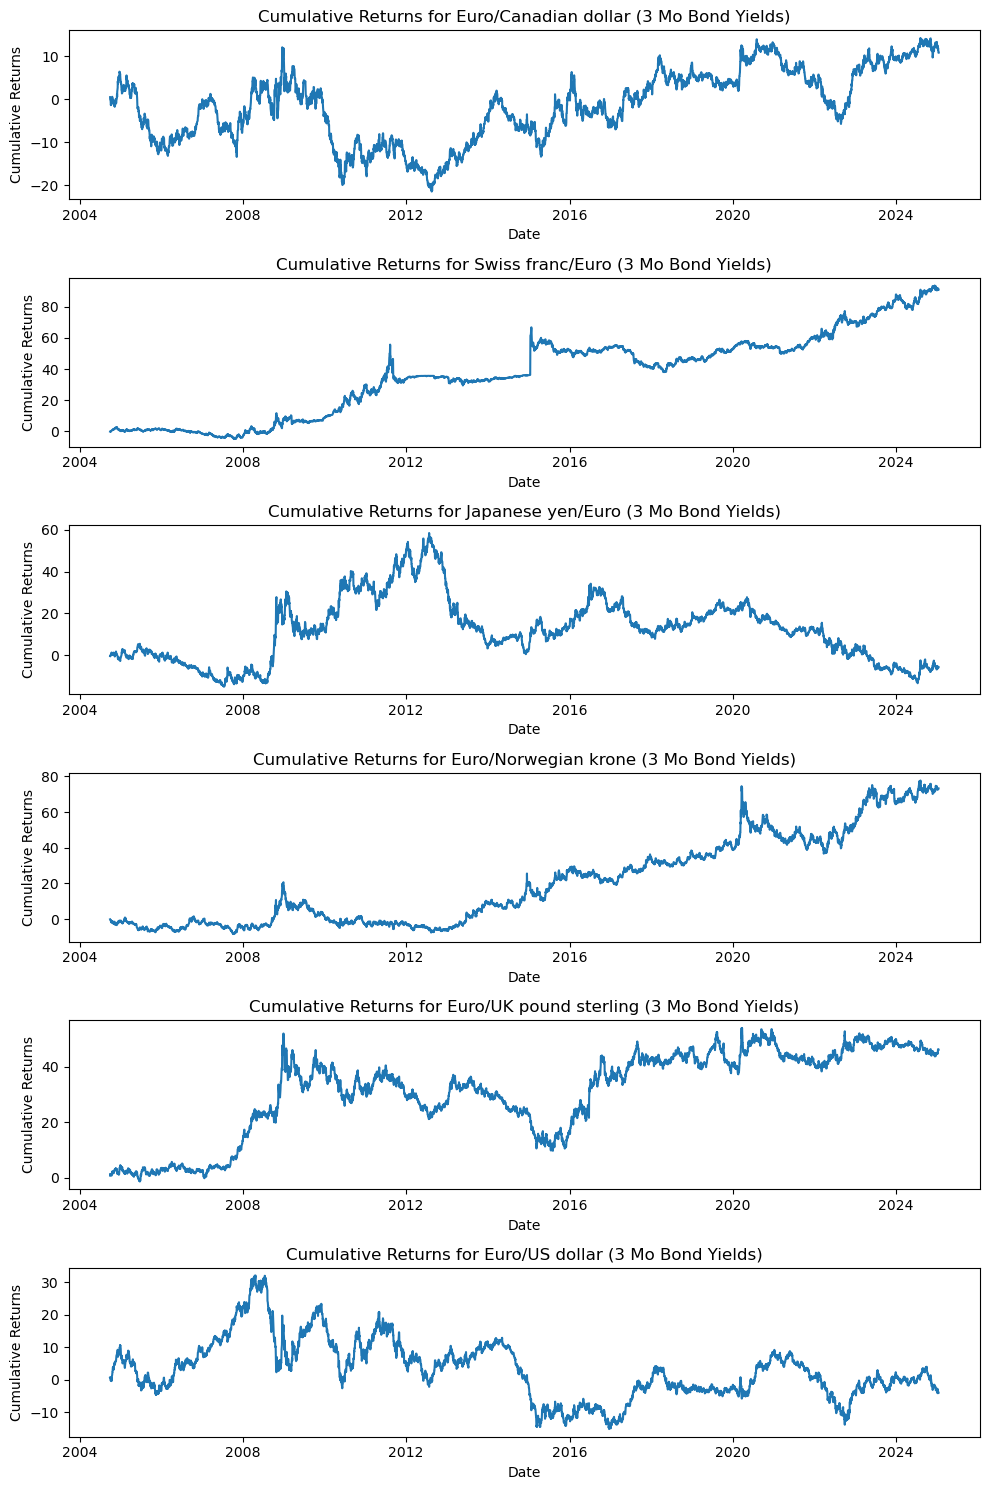

In [469]:
fig, axes = plt.subplots(nrows=len(fx_pairs), ncols=1, figsize=(10, 15))  # Adjust figsize as needed

# Loop through each FX pair and plot the cumulative returns
for i, pair in enumerate(fx_pairs):
    # Plot the cumulative returns on the corresponding subplot
    axes[i].plot(merged_df.index, merged_df[f'{pair} Cum_Returns_3m'])

    # Set the title of the subplot
    axes[i].set_title(f'Cumulative Returns for {pair} (3 Mo Bond Yields)')

    # Add labels to the axes
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Cumulative Returns')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


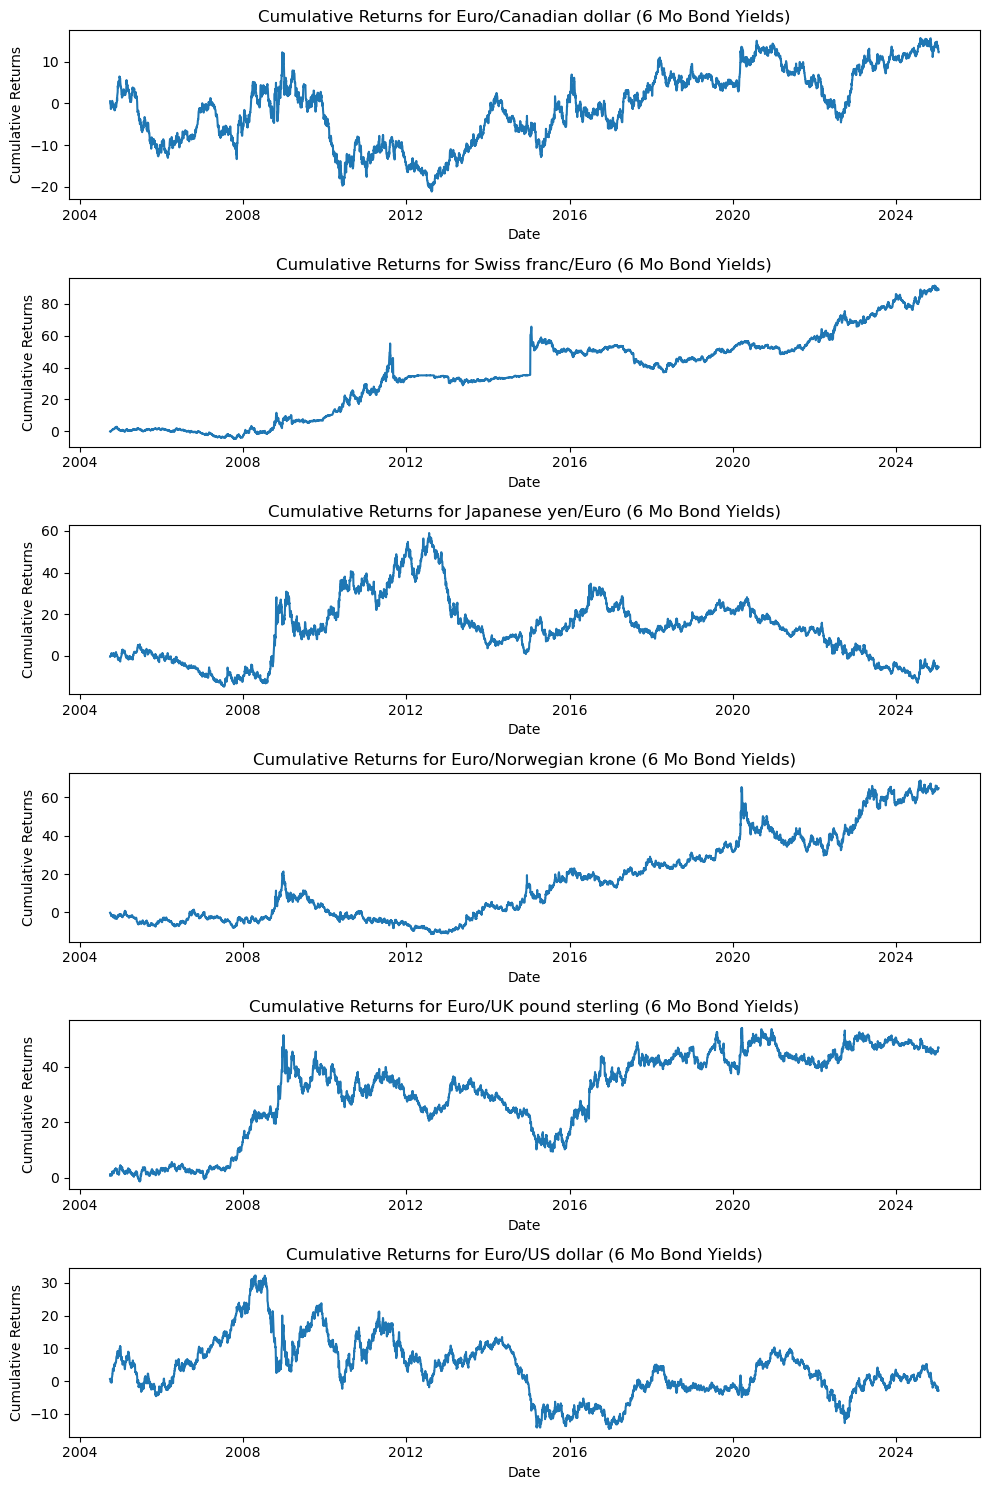

In [471]:
fig, axes = plt.subplots(nrows=len(fx_pairs), ncols=1, figsize=(10, 15))  # Adjust figsize as needed

# Loop through each FX pair and plot the cumulative returns
for i, pair in enumerate(fx_pairs):
    # Plot the cumulative returns on the corresponding subplot
    axes[i].plot(merged_df.index, merged_df[f'{pair} Cum_Returns_6m'])

    # Set the title of the subplot
    axes[i].set_title(f'Cumulative Returns for {pair} (6 Mo Bond Yields)')

    # Add labels to the axes
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Cumulative Returns')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

**Risk vs. Return for Each FX Pair Carry Strategy**

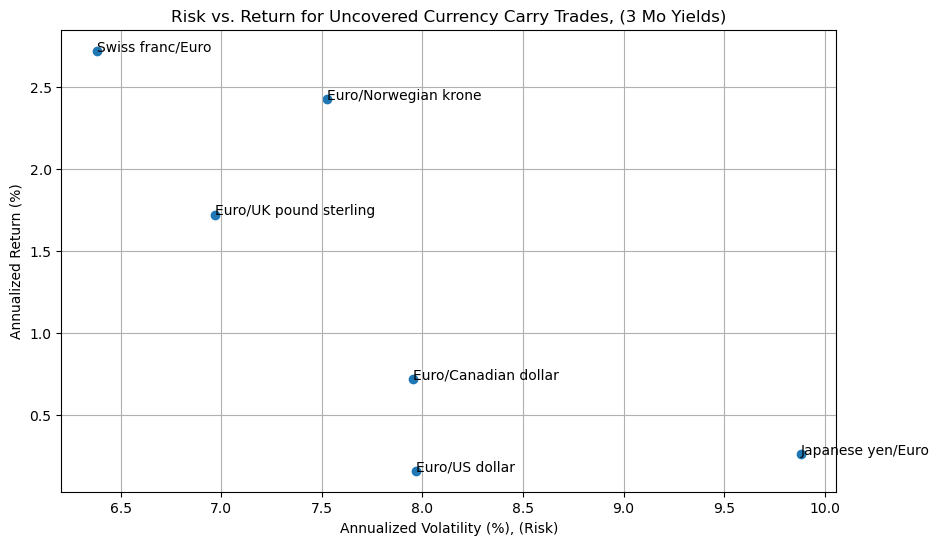

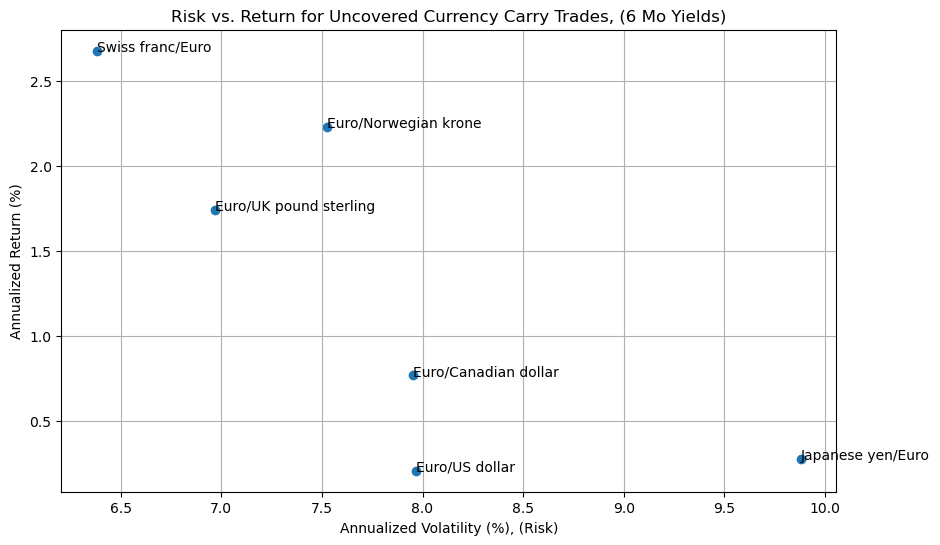

In [473]:
# Round off to 3 decimals
annualized_returns_3m = {pair: round(returns, 3) for pair, returns in annualized_returns_3m.items()}
annualized_volatilities_3m = {pair: round(vols, 3) for pair, vols in annualized_volatilities_3m.items()}
annualized_returns_6m = {pair: round(returns, 3) for pair, returns in annualized_returns_6m.items()}
annualized_volatilities_6m = {pair: round(vols, 3) for pair, vols in annualized_volatilities_6m.items()}

volatilities_3m = list(annualized_volatilities_3m.values())
returns_3m  = list(annualized_returns_3m.values())
volatilities_6m = list(annualized_volatilities_6m.values())
returns_6m  = list(annualized_returns_6m.values())

plt.figure(figsize=(10, 6))
plt.scatter(volatilities_3m, returns_3m)

plt.xlabel('Annualized Volatility (%), (Risk)')
plt.ylabel('Annualized Return (%)')
plt.title('Risk vs. Return for Uncovered Currency Carry Trades, (3 Mo Yields)')

for i, pair in enumerate(fx_pairs):
    plt.annotate(pair, (volatilities_3m[i], returns_3m[i]))
plt.grid(True)
plt.show()



plt.figure(figsize=(10, 6))
plt.scatter(volatilities_6m, returns_6m)

plt.xlabel('Annualized Volatility (%), (Risk)')
plt.ylabel('Annualized Return (%)')
plt.title('Risk vs. Return for Uncovered Currency Carry Trades, (6 Mo Yields)')

for i, pair in enumerate(fx_pairs):
    plt.annotate(pair, (volatilities_6m[i], returns_6m[i]))
plt.grid(True)
plt.show()


**Drawdown Comparison of FX Pairs Carry Strategy**

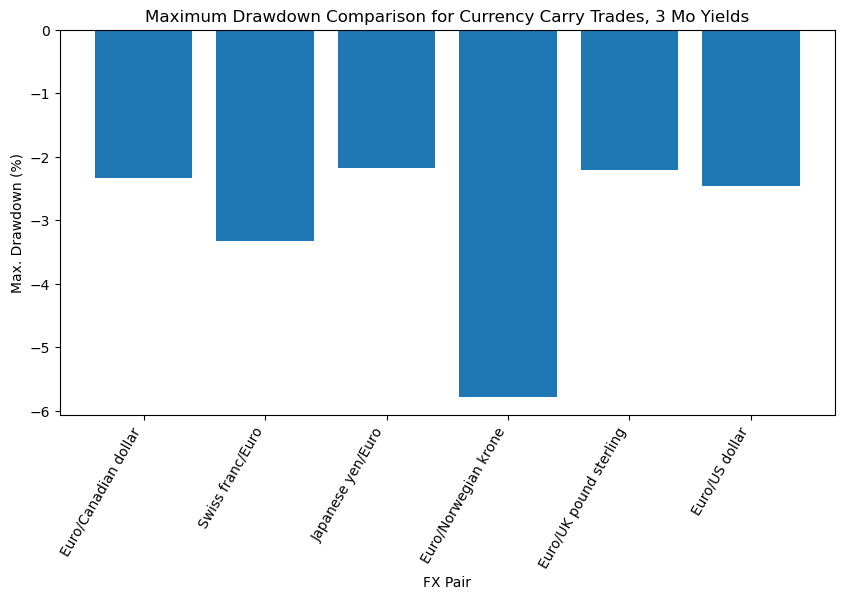

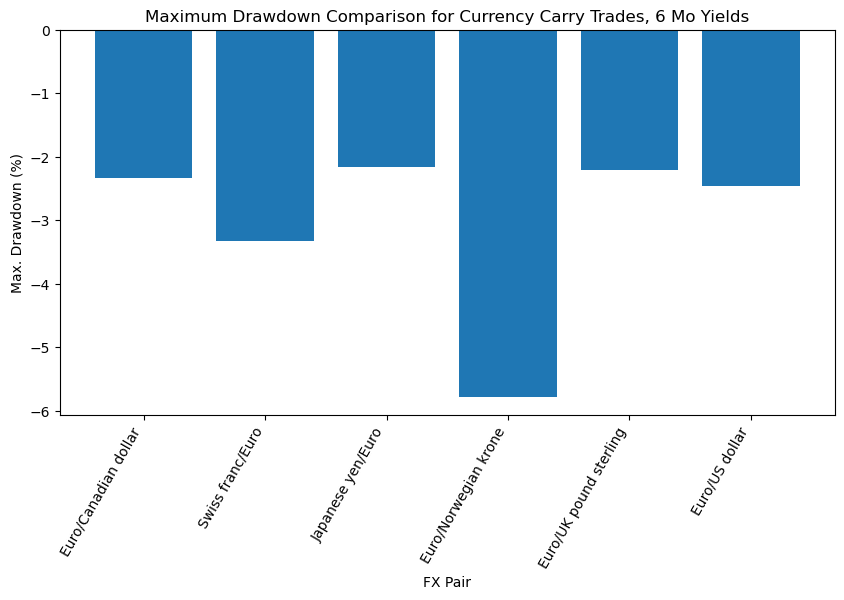

In [475]:
pairs_3m = list(max_drawdowns_3m.keys())
drawdowns_3m = list(max_drawdowns_3m.values())
pairs_6m = list(max_drawdowns_6m.keys())
drawdowns_6m = list(max_drawdowns_6m.values())

plt.figure(figsize = (10,5))
plt.bar(pairs_3m,drawdowns_3m)

plt.xlabel('FX Pair')
plt.ylabel('Max. Drawdown (%)')
plt.title('Maximum Drawdown Comparison for Currency Carry Trades, 3 Mo Yields')


plt.xticks(rotation=60, ha='right')
plt.show()

plt.figure(figsize = (10,5))
plt.bar(pairs_6m,drawdowns_6m)

plt.xlabel('FX Pair')
plt.ylabel('Max. Drawdown (%)')
plt.title('Maximum Drawdown Comparison for Currency Carry Trades, 6 Mo Yields')


plt.xticks(rotation=60, ha='right')
plt.show()


**Interest Rate Differential Over Time**

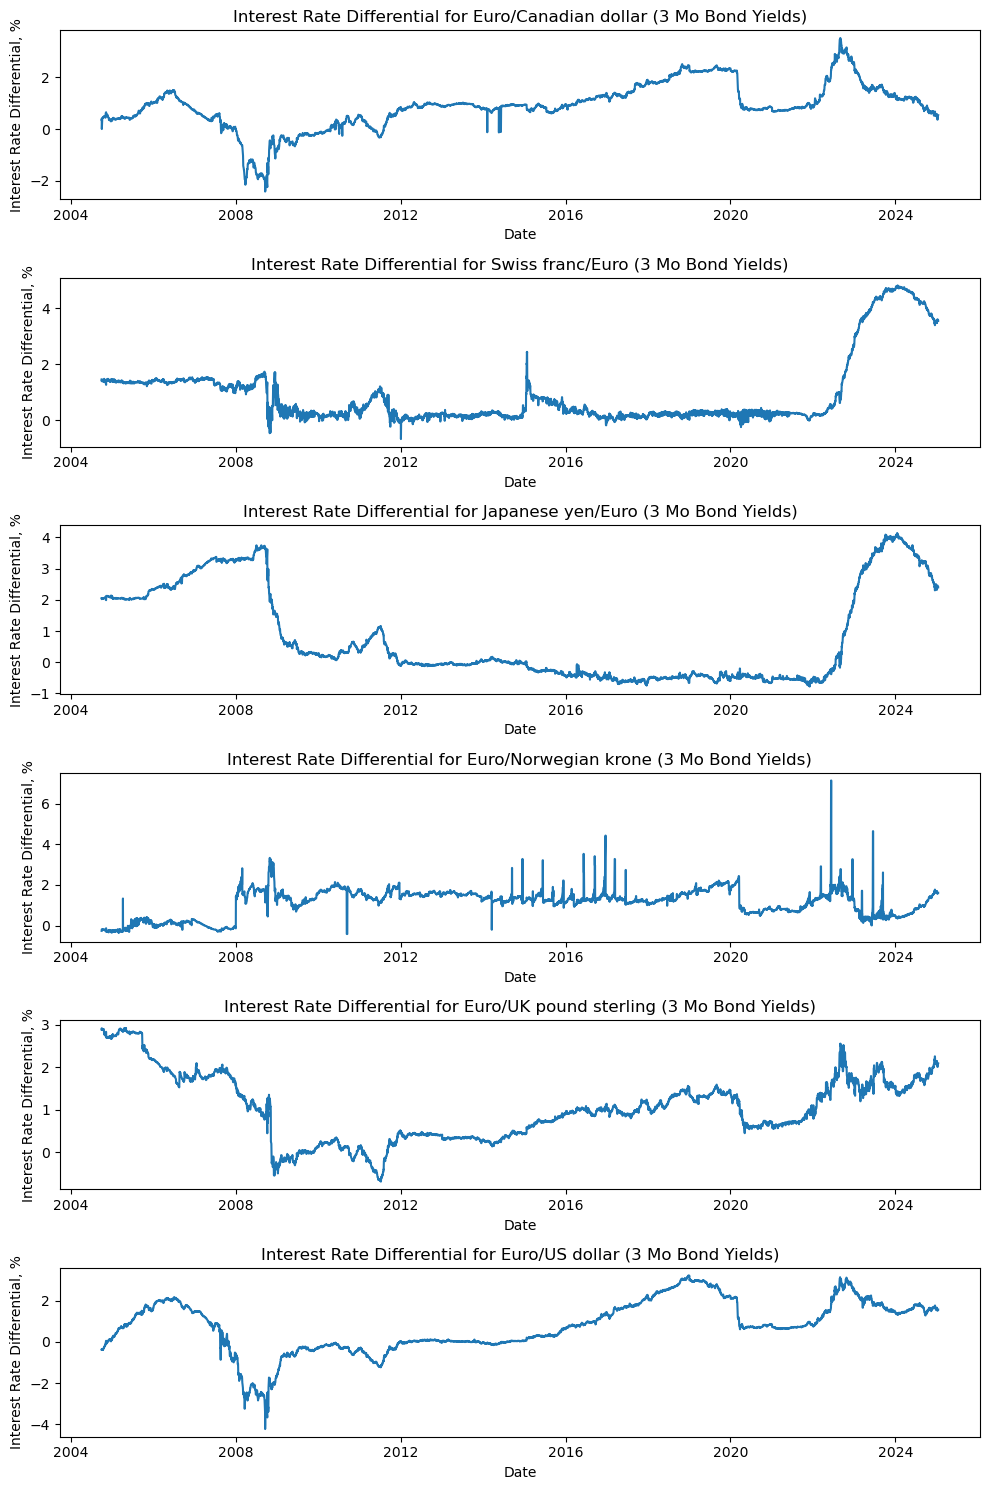

In [477]:
fig, axes = plt.subplots(nrows=len(fx_pairs), ncols=1, figsize=(10, 15))  # Adjust figsize as needed

# Loop through each FX pair and plot the cumulative returns
for i, pair in enumerate(fx_pairs):
    # Plot the cumulative returns on the corresponding subplot
    axes[i].plot(merged_df.index, merged_df[f'{pair}_diff_3m'])

    # Set the title of the subplot
    axes[i].set_title(f'Interest Rate Differential for {pair} (3 Mo Bond Yields)')

    # Add labels to the axes
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Interest Rate Differential, %')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

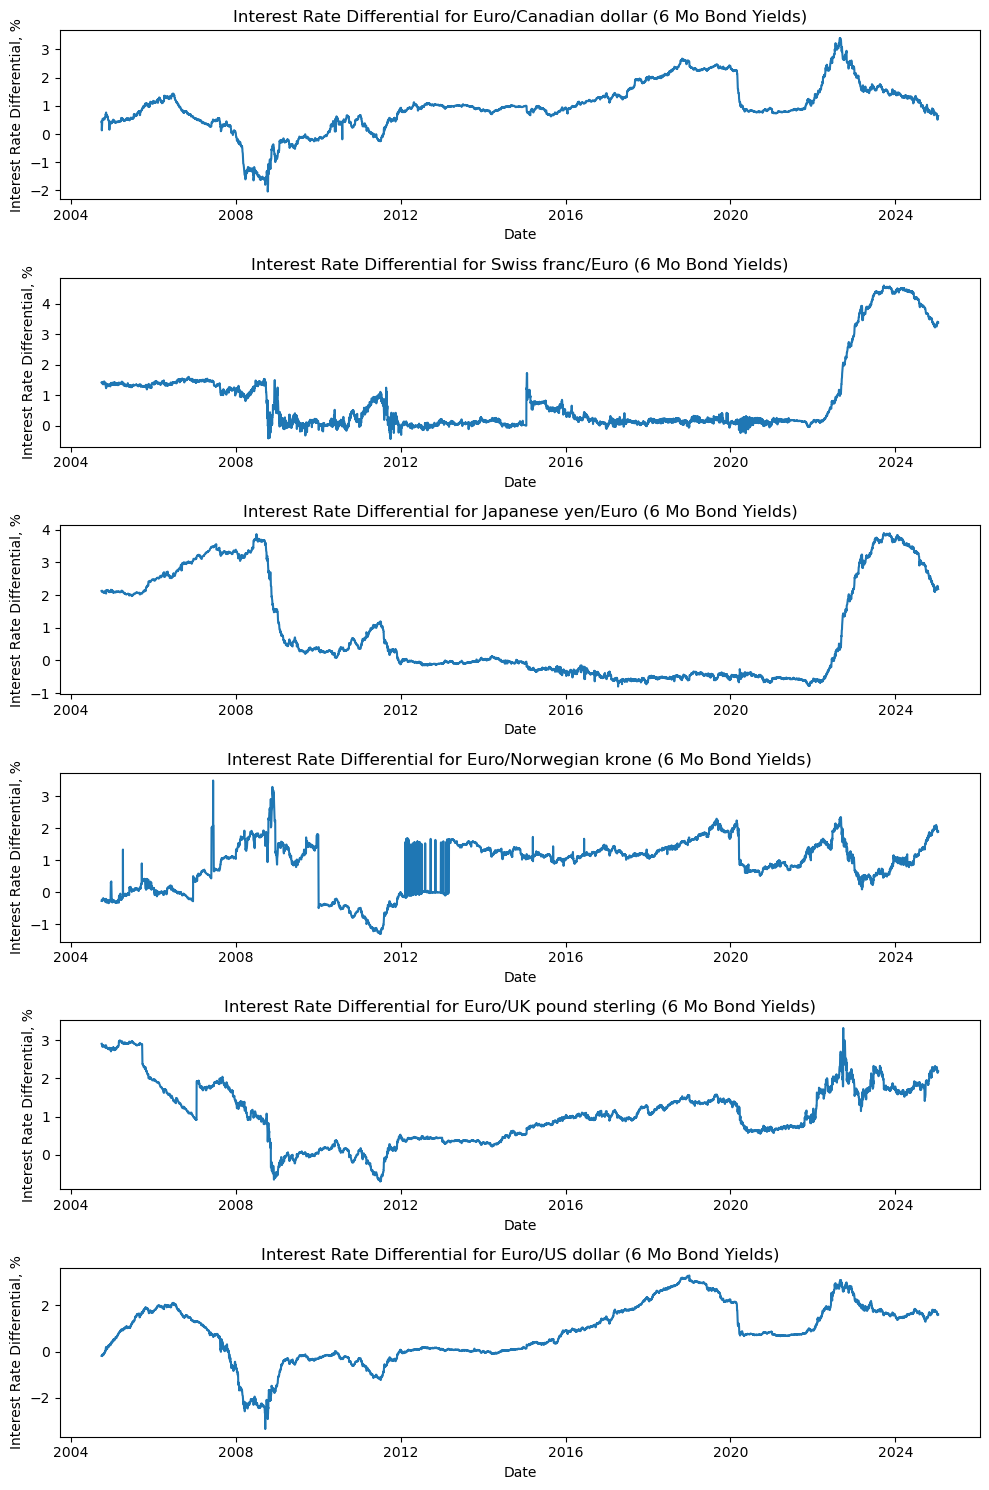

In [479]:
fig, axes = plt.subplots(nrows=len(fx_pairs), ncols=1, figsize=(10, 15))  # Adjust figsize as needed

# Loop through each FX pair and plot the cumulative returns
for i, pair in enumerate(fx_pairs):
    # Plot the cumulative returns on the corresponding subplot
    axes[i].plot(merged_df.index, merged_df[f'{pair}_diff_6m'])

    # Set the title of the subplot
    axes[i].set_title(f'Interest Rate Differential for {pair} (6 Mo Bond Yields)')

    # Add labels to the axes
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Interest Rate Differential, %')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

**Rolling Volatilities vs. Cumulative Returns over Time**

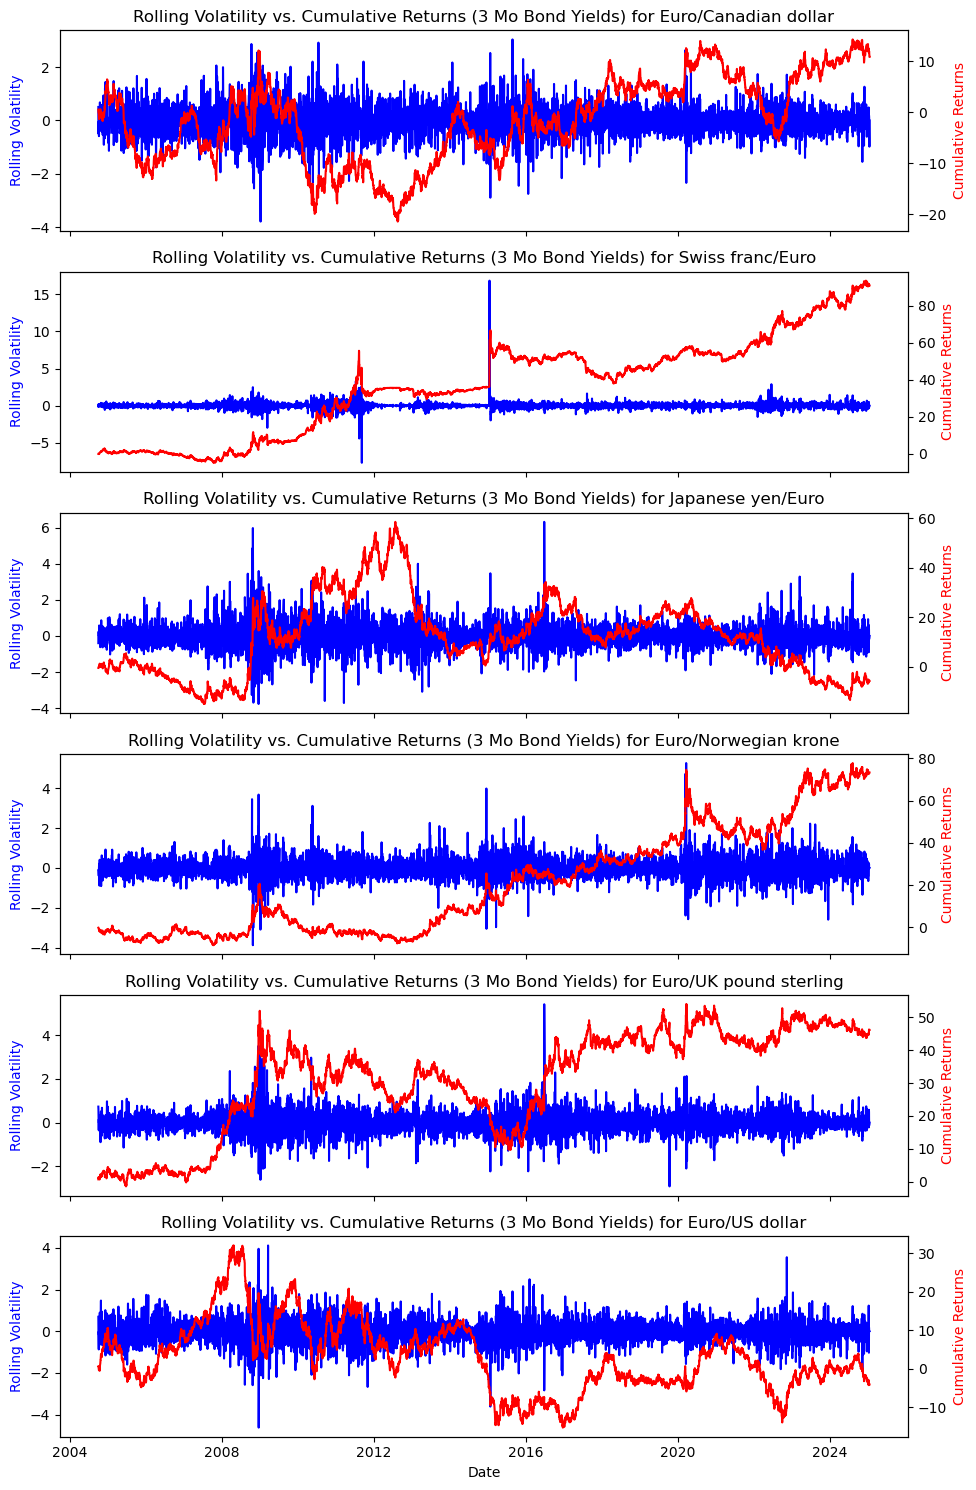

In [481]:
# Extract data for plotting
fig, axes = plt.subplots(nrows=len(fx_pairs), ncols=1, figsize=(10, 15), sharex=True)  # Adjust figsize as needed

# Loop through each FX pair and plot the rolling volatilities and cumulative returns
for i, pair in enumerate(fx_pairs):
    # Plot rolling volatilities on the left y-axis
    axes[i].plot(merged_df.index, merged_df[f'{pair}_return'], color='blue', label='Rolling Volatility')
    axes[i].set_ylabel('Rolling Volatility', color='blue')

    # Create a twin Axes sharing the xaxis for cumulative returns
    ax2 = axes[i].twinx()

    # Plot cumulative returns on the right y-axis
    ax2.plot(merged_df.index, merged_df[f'{pair} Cum_Returns_3m'], color='red', label='Cumulative Returns')
    ax2.set_ylabel('Cumulative Returns', color='red')

    # Set the title of the subplot
    axes[i].set_title(f'Rolling Volatility vs. Cumulative Returns (3 Mo Bond Yields) for {pair}')

    # Add labels to the x-axis (only for the bottom subplot)
    if i == len(fx_pairs) - 1:
        axes[i].set_xlabel('Date')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [483]:
merged_df.to_csv('fxdata.csv')

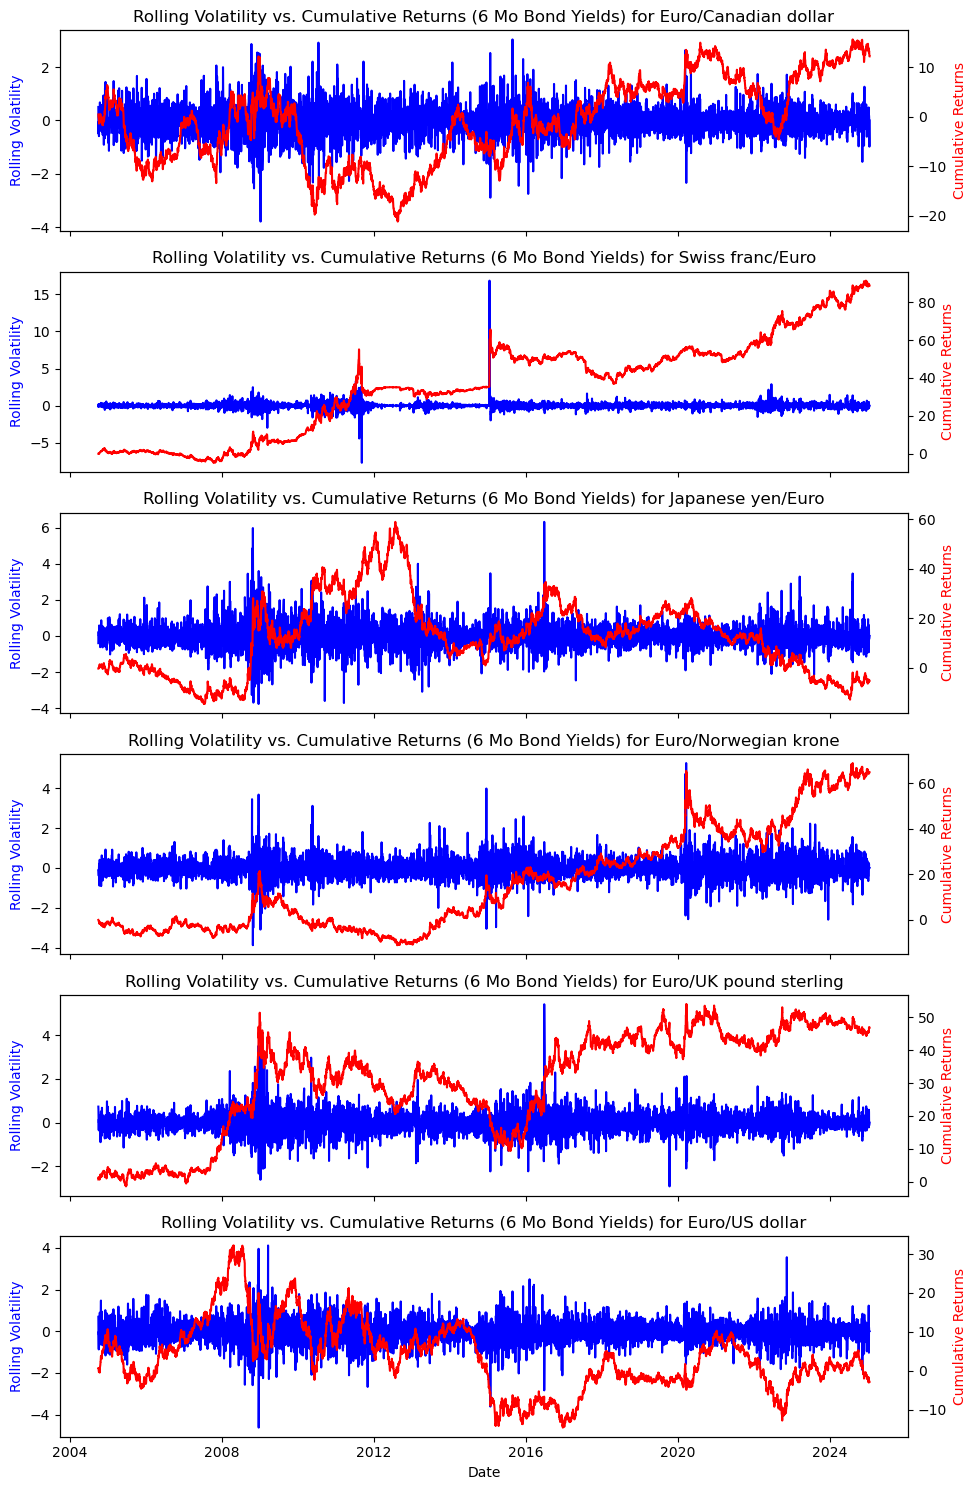

In [485]:
fig, axes = plt.subplots(nrows=len(fx_pairs), ncols=1, figsize=(10, 15), sharex=True)  # Adjust figsize as needed

# Loop through each FX pair and plot the rolling volatilities and cumulative returns
for i, pair in enumerate(fx_pairs):
    # Plot rolling volatilities on the left y-axis
    axes[i].plot(merged_df.index, merged_df[f'{pair}_return'], color='blue', label='Rolling Volatility')
    axes[i].set_ylabel('Rolling Volatility', color='blue')

    # Create a twin Axes sharing the xaxis for cumulative returns
    ax2 = axes[i].twinx()

    # Plot cumulative returns on the right y-axis
    ax2.plot(merged_df.index, merged_df[f'{pair} Cum_Returns_6m'], color='red', label='Cumulative Returns')
    ax2.set_ylabel('Cumulative Returns', color='red')

    # Set the title of the subplot
    axes[i].set_title(f'Rolling Volatility vs. Cumulative Returns (6 Mo Bond Yields) for {pair}')

    # Add labels to the x-axis (only for the bottom subplot)
    if i == len(fx_pairs) - 1:
        axes[i].set_xlabel('Date')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()